# Deep Learning Optimizer for Hydrogel Bilayer Design

*Last Edited: 2021.04.05*

***
*Important Notes*
- **5 step Patterning Step limit!**
- **Fix Analysis a.output**

*Notes*
- **min segement length[um]** = 1,000 or 800
- max strip segments: 6 ~ 8
- current best model: DigitClassifier_20201014_mod1 or 3.h5

***
* Goal: **Build an algorithm to find designs that can actuate DNA-co-polymerizer bilayer strips into multiple digits.**
    - The DNA-co-polymerizer bilayer strips are bilayer segments stacked together horizontally.
    - Currently, 4 orthogonal system of actuation + 1 dummy.

In [1]:
# Package Importing
import csv, math, os, time, copy, matplotlib, datetime, keras

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from scipy import io as spio
from scipy.ndimage import gaussian_filter
from scipy.stats import bernoulli

from math import log10, floor

from skimage import transform, exposure

print(keras.__version__) # 2.4.3
print(tf.__version__) # 2.2.0

2.4.3
2.2.0


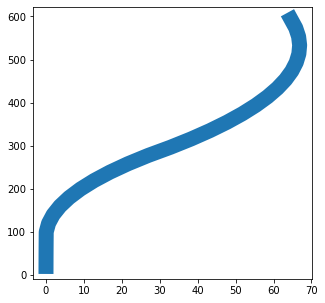

In [2]:
class SegmentedCurve:
    """
    Object that defines a curve. A curve is defined with following properties:

        1. segment lengths *list*
            - list of numbers specifying the length of each segments making up the curve.
            - unit: um
        2. rocs *list*
            - list of numbers specifying the radius of curvature of each segment.
            - set it to a high number such as 1e5 for flat line.
        3. ctls *list*
            - list of the contour length change for each segments.

    Functions:

        1. set_points
            - generate the curve as a list of points.
        2. rotate
            - rotate the curve.
        3. translate
            - translate the curve.
        4. generate_image
            - generate the image of the curve from the points.
        5. plot
            - plot the curve.
    """

    def __init__(self, segment_lengths, rocs = [], ctls = []):
        """
        By default this curve starts at (0, 0) and tangent angle 0. Deafault ROC is 999999.
        """
        
        self.segment_lengths = segment_lengths
        if not rocs:
            self.rocs = np.ones_like(segment_lengths) * 999999
        else:
            self.rocs = rocs
        if not ctls:
            self.segment_lengths = np.array(segment_lengths) 
        else:
            self.segment_lengths = np.array(segment_lengths) * ctls
         
        self.initial_point = [0, 0]
        self.initial_tangent_angle = 0
        self.set_points()
        
    def set_points(self):
        """
        Start generating the rest of the segment points from the origin and based one the segment length and ROC.
        """
        s_iter = SegmentedCurveIterator(self)
        self.x_points = []; self.y_points = []
        self.tangent_angles = []
        while True:
            try:
                element = next(s_iter)
                self.x_points.append(element[0])
                self.y_points.append(element[1])
                self.tangent_angles.append(s_iter.tangent_angle)
            except StopIteration:
                break    
    
    def rotate(self, angle):
        """
        Rotate the curve by adding an angle, and regrowing the rest of the curve.
        """
        self.initial_tangent_angle += angle
        self.set_points()
        
    def translate(self, coords):
        """
        Translate the curve by shifting its origin, and regrowing the rest of the curve.
        """
        self.initial_point += coords
        self.set_points()
        
    def generate_image(self, width = 28, height = 28, padding = 0, filter = None, filter_sigma = 1):
        """
        Generates the image of the curve.
        **Parameters**
            width *int*
                the width of the image in pixel.
            height *int*
                the height of the image in pixel.
                As the trained images are 28 x 28 pixels images, we return an image of the same size.
            padding *int*
                - provide additional space if needed.
                - not sure working or not...
            filter *string*
                Can choose None or "Gaussian", used to blur the image so it resembles the digits more.
            filter_sigma *int or float*
                Sigma for the Gaussian filter.
        """
        contour_length = np.sum(self.segment_lengths)
        half_dimension = 1.5 * contour_length / (2 * math.sqrt(2))
        #print("Old half dimension was  "+ str(half_dimension))
        x_span = np.amax(self.x_points) - np.amin(self.x_points)
        y_span = np.amax(self.y_points) - np.amin(self.y_points)
        half_dimension = max([x_span, y_span])
        #print("Half dimension is " + str(half_dimension))
        x_center = np.median(self.x_points)
        y_center = np.median(self.y_points)
        new_x = np.array(self.x_points) - x_center
        new_y = np.array(self.y_points) - y_center
        new_x = new_x * (width / 2 + padding) // half_dimension
        new_y = new_y * (height / 2 + padding) // half_dimension
        image_pixels = np.zeros(shape = (height + 2 * padding, width + 2 * padding))
        for i in range(len(new_x)):
            image_pixels[math.floor(new_y[i]) + math.floor(height / 2) + padding][math.floor(new_x[i]) + math.floor(width / 2) + padding] += 1
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        image_pixels = image_pixels / np.amax(image_pixels, axis=(0, 1))
        image_pixels = transform.resize(image_pixels, (width + padding, height + padding))
        if filter is "Gaussian":
            image_pixels = gaussian_filter(image_pixels, sigma = filter_sigma)
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        return image_pixels
    
    def generate_image_v2(self, width = 28, height = 28, padding = 0, filter = "Gaussian",\
                          filter_sigma = .8, half_dimension = 5000):
        """
        Generates the image of the curve.
        **Parameters**
            width *int*
                the width of the image in pixel.
            height *int*
                the height of the image in pixel.
                As the trained images are 28 x 28 pixels images, we return an image of the same size.
            padding *int*
                - provide additional space if needed.
                - not sure working or not...
            filter *string*
                Can choose None or "Gaussian", used to blur the image so it resembles the digits more.
            filter_sigma *int or float*
                Sigma for the Gaussian filter.
        """
        
        #print("Half dimension is " + str(half_dimension))
        x_center = np.median(self.x_points)
        y_center = np.median(self.y_points)
        new_x = np.array(self.x_points) - x_center
        new_y = np.array(self.y_points) - y_center
        new_x = new_x * (width / 2 + padding) // half_dimension
        new_y = new_y * (height / 2 + padding) // half_dimension
        image_pixels = np.zeros(shape = (height + 2 * padding, width + 2 * padding))
        for i in range(len(new_x)):
            image_pixels[math.floor(new_y[i]) + math.floor(height / 2) + padding][math.floor(new_x[i]) + math.floor(width / 2) + padding] += 1
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        image_pixels = image_pixels / np.amax(image_pixels, axis=(0, 1))
        image_pixels = transform.resize(image_pixels, (width + padding, height + padding))
        if filter is "Gaussian":
            image_pixels = gaussian_filter(image_pixels, sigma = filter_sigma)
        p50, p98 = np.percentile(image_pixels, (50, 98))
        if p98 == 0 and p50 == 0:
            p50, p98 = np.percentile(image_pixels, (50, 99))
        image_pixels = exposure.rescale_intensity(image_pixels, in_range = (p50, p98))
        return image_pixels
        
    def plot(self):
        """
        Plot and show the curve.
        """
        fig, ax = plt.subplots(1, 1, figsize = (5, 5))
        ax.plot(self.x_points, self.y_points, linewidth = 15)
        plt.show()

class SegmentedCurveIterator:
    """
    This class is mainly used as the generator for the SegmentedCurve class.
    """
    def __init__(self, segmented_curve):
        self.rocs = segmented_curve.rocs
        self.segment_starts = np.cumsum(segmented_curve.segment_lengths) - segmented_curve.segment_lengths
        self.curve_end = np.sum(segmented_curve.segment_lengths)
        self.segment_starts = np.append(self.segment_starts,[self.curve_end])
        self.last_point = segmented_curve.initial_point
        self.tangent_angle = segmented_curve.initial_tangent_angle
        self.current_length = 0; self.current_segment = 0
        # delta can be considered as the MESH SIZE for segments.
        self.delta = 20
        
    def __next__(self):
        self.current_length += self.delta
        if self.current_length > self.curve_end:
            raise StopIteration()
        if self.current_length > self.segment_starts[self.current_segment + 1]:
            self.current_segment += 1
        angle_change = self.delta / self.rocs[self.current_segment]
        self.tangent_angle += angle_change
        pos_change = [self.delta*math.sin(self.tangent_angle), \
                      self.delta*math.cos(self.tangent_angle)]
        self.last_point = np.add(self.last_point,pos_change)
        return self.last_point

# Example of a curve total length = 100um + 200um + 500um.
# And RoC = 1e5um, 670um, -830um for the radius of curvature.

s2 = SegmentedCurve([100, 200, 300],[1e5, 670, -830])
s2.plot()

In [3]:
def get_curvature(rocs, states, top_type, bottom_type):
    """
    Table reading function for retrieving the curvature and contour length change.
    """
    return rocs[int(states[int(top_type)])][int(states[int(bottom_type)])][int(top_type)][int(bottom_type)]

class ActuatorStrip:
    """
    Object that defines a bilayer hydrogel actuator. An actuator strip is defined with following properties:

        1. lengths *list*
            - list of numbers specifying the length of each segments making up the curve.
            - unit: um
        2. identities *list*
            - the actuator system that each segment is patterned with.
        3. rocs *list*
            - radius of curvature table for bilayer 
            - set it to a high number such as 1e5 for flat line.
        4. ctls *list(
            - contour length table for bilayer
    """
    
    def __init__(self, lengths, identities, rocs, ctls):
        self.segment_lengths = lengths
        self.identities = identities
        self.rocs = rocs
        self.ctls = ctls
        self.actuator_types = len(rocs[0][0]) - 1
        self.self_intersecting = []      
        self.output_info = {}
        self.selected = {}

    def generate_curves(self):
        """
        Generates the points for all possible strips formed.
        """
        self.curves = []
        for i in range(pow(2, self.actuator_types)):
            # i is an integer -- the qth bit of i in binary encodes whether the qth actuator type is on. 
            curvatures = []; ctlengths = []; states = [0]
            for k in range(self.actuator_types):
                # << bitwise shift operators
                if i & (1 << k):
                    states.append(1)
                else:
                    states.append(0)
#             print(states) # see how each image states is made
            for j in range(len(self.segment_lengths)):
                curvatures.append(get_curvature(self.rocs, states, self.identities[0][j], self.identities[1][j]))
                ctlengths.append(get_curvature(self.ctls, states, self.identities[0][j], self.identities[1][j]))
            s = SegmentedCurve(self.segment_lengths, curvatures, ctlengths)
            self.curves.append(s)
  
    def determine_self_intersection(self):
        """
        NEED A FASTER self intersecting check, currently not in use.
        """
        state_count = pow(2, self.actuator_types)
        for j in range(state_count):
            #print("Looking at self intersection " + str(j))
            #self.self_intersecting.append(self.curves[j].is_self_intersecting())
            self.self_intersecting.append(0)
            #print("Self intersecting is now " + str(self.self_intersecting))
            
    def plot_input_design(self, save = False):
        fig , ax = plt.subplots(1, figsize = (5, 5))
        fig_width = int(np.sum(self.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(self.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

        for i in range(len(self.segment_lengths)):
            ax.annotate("%dum"%(self.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(self.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(self.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")
        plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_input.png", dpi = 600)
        plt.show()
        
    def analysis(self, rotation = 20):
        
        self.generate_curves()
        bestImgs = np.zeros(shape = (16, 28, 28)); bctr = 0; HAS9 = 0; HAS6 = 0
        state_name = ["ALL OFF", "S1 ON", "S2 ON", "S1 & S2",
                      "S3 ON", "S1 & S3", "S2 & S3", "S1 & S2 & S3",
                      "S4 ON", "S1 & S4", "S2 & S4", "S1 & S2 & S4",
                      "S3 & S4", "S1 & S3 & S4", "S2 & S3 & S4", "ALL ON"]
        rotations = []
        
        for curve in self.curves:
            possibility = np.zeros(shape = (rotation, 28, 28)); ctr = 0
            
            for _ in range(rotation):
                curve.rotate(2*math.pi / rotation)
                img = curve.generate_image(filter = 'Gaussian')
                possibility[ctr]=img;ctr+=1
            score = cnn_digit_model.predict(possibility.reshape(possibility.shape[0], 28, 28, 1))
            info = [(i, np.argmax(score[i]), score[i][np.argmax(score[i])]) for i in range(len(score)) if np.argmax(score[i]) < 10]

            if info:
                best = np.argmax([info[i][2] for i in range(len(info))])
                if info[best][1] == 9:
                    if not HAS9:
                        HAS9 = True
                        bestImgs[bctr] = possibility[info[best][0]]
                    elif not HAS6:
                        try: 
                            best = [info[i][1] for i in range(len(info))].index(6)
                            bestImgs[bctr] = possibility[info[best][0]]
                        except:
                            bestImgs[bctr] = possibility[info[best][0]]
                    else:
                        bestImgs[bctr] = possibility[info[best][0]]
                elif info[best][1] == 6:
                    if not HAS6:
                        HAS6 = True
                        bestImgs[bctr] = possibility[info[best][0]]
                    elif not HAS9:
                        try: 
                            best = [info[i][1] for i in range(len(info))].index(9)
                            bestImgs[bctr] = possibility[info[best][0]]
                        except:
                            bestImgs[bctr] = possibility[info[best][0]]
                    else:
                        bestImgs[bctr] = possibility[info[best][0]]
                else:
                    bestImgs[bctr] = possibility[info[best][0]]
            else:
                bestImgs[bctr] = possibility[-2]
            rotations.append((best+1)*2*math.pi / rotation)
            bctr += 1
        score = cnn_digit_model.predict(bestImgs.reshape(16, 28, 28, 1))
        info = [(np.argmax(score[i]), score[i][np.argmax(score[i])]) for i in range(len(score))]
        
        
        self.output_info = {i:{"img":bestImgs[i], "dig":info[i][0], "score":info[i][1], "state":state_name[i],\
                               "rotations":rotations[i]} for i in range(16)}

        contest = [[] for i in range(11)];
        [contest[self.output_info[i]["dig"]].append((self.output_info[i]["score"], i)) for i in self.output_info]
        for i in range(11):
            if contest[i] and i!=10:
                self.selected[i] = {"img":self.output_info[sorted(contest[i])[-1][1]]["img"],\
                                    "score":sorted(contest[i])[-1][0],\
                                    "num":sorted(contest[i])[-1][1],\
                                    "state":self.output_info[sorted(contest[i])[-1][1]]["state"]}
                
    def generate_unscaled_imgs(self, filter_sigma = .8, half_dimension = 5000):
        
        self.generate_curves(); self.unscaled_imgs = np.zeros(shape = (16, 28, 28))

        for i in range(16):
            curve = self.curves[i]; curve.rotate(self.output_info[i]["rotations"])
            img = curve.generate_image_v2(filter_sigma = filter_sigma, half_dimension = half_dimension)
            self.unscaled_imgs[i] = img
                
    def plot_output_map(self, score = True, save = False):
        
        state_count = pow(2, self.actuator_types)
        if state_count != 16:
            raise WrongDesignType()
            
        title_name = ["ALL OFF", "S1 ON", "S2 ON", "S1 & S2",
              "S3 ON", "S1 & S3", "S2 & S3", "S1 & S2 & S3",
              "S4 ON", "S1 & S4", "S2 & S4", "S1 & S2 & S4",
              "S3 & S4", "S1 & S3 & S4", "S2 & S3 & S4", "ALL ON"]
        fig = plt.figure(figsize = (6,6)); ctr = 0
        
        self.generate_curves()
        for i in range(state_count):
            plt.subplot(4, 4, ctr+1)
            curve = self.curves[i]; img = curve.generate_image(filter = 'Gaussian')
            plt.imshow(img)
            plt.title(title_name[i], fontsize = 10, family = "serif", weight = "bold", y = .95)
            if score:
                scores = cnn_digit_model.predict(img.reshape(1,28,28,1))[0]
                plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(np.argmax(scores), np.max(scores)), fontsize = 12, family = "serif", weight = "bold", color = "white")
            plt.axis(False); ctr += 1
        fig.suptitle("Output Map", fontsize = 12, family = "serif", weight = "bold", y = .95)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_output.png", dpi = 600)
        plt.show()
        
    def plot_advanced_output_map(self, rotation = 20, save = False):
        """
        - Enables rotation and mirroring to search larger space
        - Enables simultaneous presense of 6 and 9
        """

        if not self.output_info or rotation != 20:
            self.analysis(rotation = rotation)
        
        fig = plt.figure(figsize = (6,6)); ctr = 0
        
        for i in range(pow(2, self.actuator_types)):
            plt.subplot(4, 4, ctr+1)
            img = self.output_info[ctr]["img"]
            plt.imshow(img)
            plt.title(self.output_info[ctr]["state"], fontsize = 10, family = "serif", weight = "bold", y = .95)
            plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(self.output_info[ctr]["dig"], self.output_info[ctr]["score"]), fontsize = 12, family = "serif", weight = "bold", color = "white")
            plt.axis(False); ctr += 1
        fig.suptitle("Output Map", fontsize = 12, family = "serif", weight = "bold", y = .95)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_advancedoutput.png", dpi = 600)
        plt.show()
        
    def plot_selected_output_map(self, rotation = 20, save = False):

        if not self.selected or rotation != 20:
            self.analysis(rotation = rotation)
        
        fig = plt.figure(figsize = (10, 4))
        
        for i in range(10):
            plt.subplot(2, 5, i+1)
            if i in self.selected.keys():
                img = self.selected[i]['img']
                plt.imshow(img)
                plt.text(img.shape[1]*.05, img.shape[1]*.9, "Score: {:.3f}".format(self.selected[i]['score']), fontsize = 12, family = "serif", weight = "bold", color = "white")
                plt.title("{} ({})".format(i, self.selected[i]['state']), fontsize = 10, family = "serif", weight = "bold", y = .98)
            else:
                plt.imshow(np.zeros(shape = (28, 28)))
                plt.title("{} (n.a.)".format(i), fontsize = 10, family = "serif", weight = "bold", y = .98)
            plt.axis(False)
        fig.suptitle("Optimized Output Map", fontsize = 15, family = "serif", weight = "bold", y = .98)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_selectedoutput.png", dpi = 600)
        plt.show()
        
    def plot_input_and_all(self, rotation = 20, save = False):
        
        if not self.selected or rotation != 20:
            self.analysis(rotation = rotation)
            
        fig = plt.figure(figsize=(12,6))
        
        ax = plt.subplot(1,2,1)
        fig_width = int(np.sum(self.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(self.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

        for i in range(len(self.segment_lengths)):
            ax.annotate("%dum"%(self.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(self.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(self.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")
        plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)
             
        ctr = 0; shiftlist = [5,5,5,5,9,9,9,9,13,13,13,13,17,17,17,17]
        for i in range(pow(2, self.actuator_types)):
            plt.subplot(4, 8, ctr + shiftlist[ctr])
            img = self.output_info[ctr]["img"]
            plt.imshow(img)
            plt.title(self.output_info[ctr]["state"], fontsize = 10, family = "serif", weight = "bold", y = .95)
            plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(self.output_info[ctr]["dig"], self.output_info[ctr]["score"]), fontsize = 12, family = "serif", weight = "bold", color = "white")
            plt.axis(False); ctr += 1
            
        fig.suptitle("Design Input and Output Map", fontsize = 15, family = "serif", weight = "bold", y = .95)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_inandoutput.png", dpi = 600)
        plt.show()
        
    def plot_input_and_selected(self, rotation = 20, save = False):
        
        if not self.selected or rotation != 20:
            self.analysis(rotation = rotation)
            
        fig = plt.figure(figsize=(16,4))
        
        ax = plt.subplot(1,4,1)
        fig_width = int(np.sum(self.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(self.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(self.segment_lengths[0:i])),strip_width,self.segment_lengths[i], color = cm.colors[self.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 11, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 11, color = "white", family = "serif", weight = "bold")

        for i in range(len(self.segment_lengths)):
            ax.annotate("%dum"%(self.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(self.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(self.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 11, color = "white", family = "serif", weight = "bold")
        plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)
        plt.subplots_adjust(wspace = 0.01, hspace = .2)
        
        shiftlist = list(range(3,8))+list(range(10,15))
        for i in range(10):
            plt.subplot(2, 7, shiftlist[i])
            if i in self.selected.keys():
                img = self.selected[i]['img']
                plt.imshow(img)
                plt.text(img.shape[1]*.05, img.shape[1]*.9, "Score: {:.3f}".format(self.selected[i]['score']), fontsize = 12, family = "serif", weight = "bold", color = "white")
                plt.title("{} ({})".format(i, self.selected[i]['state']), fontsize = 12, family = "serif", weight = "bold", y = .98)
            else:
                plt.imshow(np.zeros(shape = (28, 28)))
                plt.title("{} (n.a.)".format(i), fontsize = 12, family = "serif", weight = "bold", y = .98)
            plt.axis(False)
        fig.suptitle("Design Input and Optimized Output Map", fontsize = 16, family = "serif", weight = "bold", y = 1.05)
        plt.subplots_adjust(wspace = 0.01, hspace = .2)
        if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_selectedoutput.png", dpi = 600)
        plt.show()
        
    def save_imgs(self, rotation = 20, path = os.getcwd()):
        
        if not self.output_info or rotation != 20:
            self.analysis(rotation = rotation)
            
        for i in range(16):
            try:
                objt = self.output_info; foldername = "d{}".format(objt[i]["dig"]); filename = datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S_%f") + "_output.png";
                plt.imsave("/".join((path, foldername, filename)), objt[i]["img"])
            except:
                continue
        
# segment_lengths_ex_four_types = [938, 954, 1022, 1333, 1333]
# segment_identities_ex_four_types = [[2,3,2,2,3],[1,2,4,4,3]]
# a = ActuatorStrip(segment_lengths_ex_four_types, segment_identities_ex_four_types, four_t_rocs, four_t_ctls)
# # a.generate_curves()
# cnn_digit_model = load_model("CNN_dig_RSQ2_v1.h5")
# a.plot_input_and_all()
# a.plot_input_and_selected()


In [4]:
# # create folders for digit images saving
# for i in range(11):
#     os.mkdir("d{}".format(i))
# print("Folders Made!")


## Actuator System Parameters

**Radius of Curvature**

|S1.2 RoC [um]|1 OFF Second round|1 ON/ OTHER OFF|
|---|---|---|
|S1.2|nc  |-  |
|S2.2|1430|670+100=770|
|S5  |1430|625+100=725|
|S6.2|1430|590+100=690|
|No DNA|assume 5e3|assume 630+100=730|

|S2.2 RoC [um]|BOTH OFF|2 ON/ OTHER OFF|
|---|---|---|
|S1.2|1540|670+150=820|
|S2.2|nc|-|
|S5  |1250|500+150=650|
|S6.2|1430|545+150=695|
|No DNA|assume 5e3|assume 590+150=740|

|S5 RoC [um]|BOTH OFF|3 ON/ OTHER OFF|
|---|---|---|
|S1.2|1200|570|
|S2.2|1550|667|
|S5  |nc|-|
|S6.2|1250|830|
|No DNA|assume 5e3|assume 770|

|S6.2 RoC [um]|BOTH OFF|4 ON/ OTHER OFF|
|---|---|---|
|S1.2|1060|500|
|S2.2|1250|667|
|S5  |2000|670|
|S6.2|nc|-|
|No DNA|assume 5e3|assume 630|

**RoC Matrix**

*Definition*

- RoC bending downward is positive, bending upward (ex. shape U) negative. 
- **nc**: for no curvature = 1e5, **-**: for no value, but still put in 1e8 to avoid confusing the table.
- Lacking most data for pos_pos matrix, for systems sharing similar swelling behavior (sys 1, 2, 4) when both swollen, assume RoC = nc; for system 3, that swells a lot, assume slight bending caused and value = 3500um.

|top neg, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|nc  |5e3|5e3|5e3|5e3|
|1|-5e3|nc |nc |nc |nc |
|2|-5e3|nc |nc |nc |nc |
|3|-5e3|nc |nc |nc |nc |
|4|-5e3|nc |nc |nc |nc |

|top pos, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|-|-|-|-|
|1|-|nc|*assumed nc*|3500|*assumed nc*|
|2|-|*assumed nc*|nc|3500|*assumed nc*|
|3|-|-3500|-3500|nc|-3500|
|4|-|*assumed nc*|*assumed nc*|3500|nc|

|top pos, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|730|740|770|630|
|1|-|-  |820|570|500|
|2|-|770|-  |667|667|
|3|-|725|650|-  |670|
|4|-|690|695|830|-  |

|top neg, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-   |-   |-   |-   |-   |
|1|-730|-   |-770|-725|-690|
|2|-740|-820|-   |-650|-695|
|3|-770|-570|-667|-   |-830|
|4|-630|-500|-667|-670|-   |

**Delta Contour Lengths**

||S1.2 Contour Length|
|--- |---|
|S1.2|from monolayer (second round), 0.45|
|S2.2|0.24|
|S5  |0.18|
|S6.2|0.19|

||S2.2 Contour Length|
|--- |---|
|S1.2|0.16|
|S2.2|from monolayer (second round), (0.45)|
|S5  |0.2|
|S6.2|0.23|

||S5 Contour Length|
|--- |---|
|S1.2|0.32|
|S2.2|0.59|
|S5  |from monolayer (second round), 0.7|
|S6.2|0.32|

||S6.2 Contour Length|
|--- |---|
|S1.2|0.25|
|S2.2|0.5|
|S5  |0.35|
|S6.2|from monolayer (second round), 0.4|

**Contour Matrix**

- for pos_pos, use the value from monolayer for diagonals, and slightly uptune/downtune for paired systems.
- for pos_neg, downtune .2 for connection with no-DNAs.

|top neg, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|1|1|1|1|1
|1|1|1|1|1|1
|2|1|1|1|1|1
|3|1|1|1|1|1
|4|1|1|1|1|1

|top pos, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|-|-|-|-|
|1|-|1.45|assume 1.4|assume 1.55|assume 1.42|
|2|-|assume 1.4|assume 1.4|assume 1.5|assume 1.4|
|3|-|assume 1.55|assume 1.5|1.75|assume 1.55|
|4|-|assume 1.42|assume 1.4|assume 1.55|1.45|

|top pos, bot neg|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-|assume 1.22|assume 1.14|assume 1.3|assume 1.33|
|1|-|   -|1.16|1.32|1.25|
|2|-|1.24|-   |1.59|1.50|
|3|-|1.18|1.20|-   |1.35|
|4|-|1.19|1.23|1.32|-   |

|top neg, bot pos|0|1|2|3|4|
|---|---|---|---|---|---|
|0|-          |   -|   -|   -|   -|
|1|assume 1.22| -  |1.24|1.18|1.19|
|2|assume 1.14|1.16|-   |1.20|1.23|
|3|assume 1.30|1.32|1.59|-   |1.32|
|4|assume 1.33|1.25|1.50|1.35|-   |

In [5]:
# Set up the RoC matrix
actuator_types = 4; nc = 1e5; na = 1e8
neg_neg_rocs = [[nc, 5e3, 5e3, 5e3, 5e3],[-5e3, nc, nc, nc, nc],[-5e3, nc, nc, nc, nc],[-5e3, nc, nc, nc, nc],[-5e3, nc, nc, nc, nc]]
pos_pos_rocs = [[na, na, na, na, na],[na, nc, nc, 3500, nc],[na, nc, nc, 3500, nc],[na, -3500, -3500, nc, -3500],[na, nc, nc, 3500, nc]]
pos_neg_rocs = [[na, 730, 740, 770, 630],[na, na, 820, 570, 500],[na, 770, na, 667, 667],[na, 725, 650, nc, 670],[na, 690, 695, 830, na]]
neg_pos_rocs = [[na, na, na, na, na],[-730, na, -770, -725, -690],[-740, -820, na, -650, -695],[-770, -570, -667, na, -830],[-630, -500, -667, -670, na]]
four_t_rocs = [[neg_neg_rocs, neg_pos_rocs],[pos_neg_rocs, pos_pos_rocs]]

# Set up the ContourLength matrix
na = 1
neg_neg_ctls = [[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1]]
pos_pos_ctls = [[na, na, na, na, na],[na, 1.45, 1.4, 1.55, 1.42],[na, 1.4, 1.4, 1.5, 1.4],[na, 1.55, 1.5, 1.75, 1.55],[na, 1.42, 1.4, 1.55, 1.45]]
pos_neg_ctls = [[na, 1.22, 1.14, 1.3, 1.33],[na, na, 1.16, 1.32, 1.25],[na, 1.24, na, 1.59, 1.50],[na, 1.18, 1.20, nc, 1.35],[na, 1.19, 1.23, 1.32, na]]
neg_pos_ctls = [[na, na, na, na, na],[1.22, na, 1.24, 1.18, 1.19],[1.14, 1.16, na, 1.20, 1.23],[1.3, 1.32, 1.59, na, 1.32],[1.33, 1.25, 1.50, 1.35, na]]
four_t_ctls = [[neg_neg_ctls, neg_pos_ctls],[pos_neg_ctls, pos_pos_ctls]]

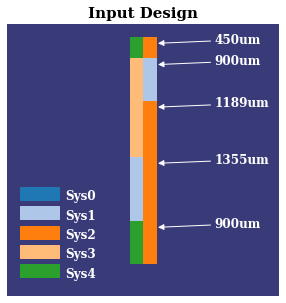

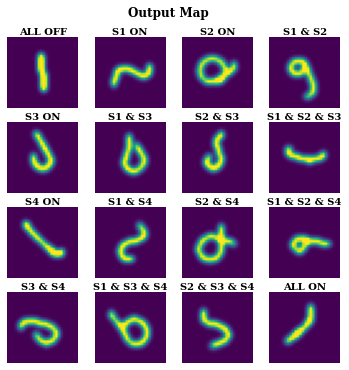

In [8]:
segment_lengths_ex_four_types = [450, 900, 1189, 1355, 900]
segment_identities_ex_four_types = [[4,3,3,1,4],[2,1,2,2,2]]
a = ActuatorStrip(segment_lengths_ex_four_types, segment_identities_ex_four_types, four_t_rocs, four_t_ctls)
cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")
# a.generate_curves()
a.plot_input_design()
a.plot_output_map(score=False)
# a.plot_input_and_all()

## Evolution History of the Project

In [9]:
# Sample random design
# max_seg = 7
# segment_lengths_ex_four_types = np.random.random(size = (max_seg,)) * 500 + 600
# segment_identities_ex_four_types = np.random.randint(0, high=(4 + 1),size = (2, max_seg))
# print(segment_lengths_ex_four_types)
# print(segment_identities_ex_four_types)

# Sample Design
# 447.00237374  907.26817329 1176.51880725 1355.23921038  894.26759248]
segment_lengths_ex_four_types = [938, 954, 1022, 843, 931, 722, 702, 655, 1066, 947]
segment_identities_ex_four_types = [[2,3,2,3,2,3,4,0,1,4],[4,4,3,1,3,4,4,1,3,2]]
b = ActuatorStrip(segment_lengths_ex_four_types, segment_identities_ex_four_types, four_t_rocs, four_t_ctls)
# a.generate_curves()

# set model for classification
# CNN_dig_v1,  CNN_dig_RSQ2_v1
# a.plot_input_design(save = True)
# print("In the beginning, we started with MNIST trained CNN, but has low accuracy.")
# cnn_digit_model = load_model("CNN_dig_v1.h5")
# a.plot_output_map(score = True, save = False)
# print("We later added strip data to improve accuracy and enable random squiggle identification.")

# cnn_digit_model = load_model("CNN_dig_v1.h5")
# a.plot_input_design(save = False)
# a.plot_output_map(score = False, save = False)
# a.plot_output_map(score = True, save = False)
# print("We further increased the searching space vi`a rotation and mirroring")
# a.plot_input_and_all(rotation = 10, save = False)
# a.plot_input_and_selected(rotation = 20, save = False)
cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")

## Design Parameters

1. **6 (8) segments**
2. **min seg length = 1000 um(or 800)**

Are able to form some interesting structures.

**loss function to be minimized**

In [10]:
def loss_on_dig_sim_var_v2(strip, rotation = 20):
    """
    - loss on digit similarity and variety
    - default 20 rotations
    - Final design score list would be stored in a np array, documenting the max score for each digit.
    - Reconsider np.log as log would greatly lock into one design for a perfect 1 or 7, as log(1-1) = -inf
    
    The loss is then calculated by the following:
    
        digits_for_score = np.log(1 - digit_recs) * 5000 * digits_form)
        loss = np.sum(digits_for_score)

    Where we're taking the log of each value's distance against one, and scaling with the digit numbers that it can form.
    For design that can form more digit number and higher similairy, they can get lower loss.
    """
    strip.analysis(rotation = rotation); output = strip.selected
    dig_score = np.zeros(shape=(10, ))
    
    if output.keys():
        for i in output.keys():
            dig_score[i] = output[i]["score"] 
#     did 1.001 - dig_score as -inf often appears when 1 is in dig_score
    loss = np.sum(np.log(1.001 - dig_score) * 5000 * np.count_nonzero(dig_score))
    
    return loss

loss_on_dig_sim_var_v2(b, rotation = 4) # -2080099.4708855439 if 0, messed up, restart kernal


-2275695.1417187443

**NEw update Function for mutation that limits fab complexity**

In [11]:
def fab_steps_strip_requires(identities):
    top_steps = np.size(np.unique(identities[0]))
    bottom_steps = np.size(np.unique(identities[1]))
    return top_steps + bottom_steps                    

def sp_mutation_maxfab_v1(parent_strip, max_segments, min_segment_length,\
                          max_segment_length, max_fab_steps, rocs, ctls, num_actuator_types):
    """
    - single parent mutation
    - v1 seems to be unable to produce new identities
    - v2 now has 40% new identities chance, and can retain 80% of original genetic info
    """
    # 50% chance in length change
    if np.random.random() < .5:
#         print("length change")
        new_length = np.random.random(size = (max_segments, )) * (max_segment_length - min_segment_length) + min_segment_length
        offspring_strip = ActuatorStrip(new_length, parent_strip.identities, rocs, ctls) 
    # 50% chance in acutator change, mutates 50% of identities
    else:
#         print("idt change")
        satisfy_max_fab = False
        while satisfy_max_fab == False:
            identities_mutation_rate = .5
            sz = int(np.floor(len(parent_strip.identities[0]) * identities_mutation_rate))
            new_identities = copy.deepcopy(parent_strip.identities)
            for i in range(2):
                gene_num = np.random.choice(len(parent_strip.identities[0]), size=(sz,), replace = False)
                new_genes = np.random.choice(num_actuator_types + 1, size = (sz,))
                for j in range(sz): new_identities[i][gene_num[j]] = new_genes[j] 
            if (fab_steps_strip_requires(new_identities) <= max_fab_steps):
                satisfy_max_fab = True
        offspring_strip = ActuatorStrip(parent_strip.segment_lengths, new_identities, rocs, ctls) 

        
    
    return offspring_strip

# b = sp_mutation_v2(a, 100, 600, four_t_rocs, four_t_ctls, 4)
# print(a.identities)
# print(b.identities)
# print(a.segment_lengths)
# print(b.segment_lengths)


**Update Function for mutation -- old, no restrictions on fab complexity**

In [12]:
def sp_mutation_v2(parent_strip, max_segments, min_segment_length,\
                   rocs, ctls, num_actuator_types):
    """
    - single parent mutation
    - v1 seems to be unable to produce new identities
    - v2 now has 40% new identities chance, and can retain 80% of original genetic info
    """
    # 50% chance in length change
    if np.random.random() < .5:
#         print("length change")
        new_length = np.random.random(size = (max_segments, )) * min_segment_length + min_segment_length
        offspring_strip = ActuatorStrip(new_length, parent_strip.identities, rocs, ctls) 
    # 50% chance in acutator change, mutates 50% of identities
    else:
#         print("idt change")
        identities_mutation_rate = .5
        sz = int(np.floor(len(parent_strip.identities[0]) * identities_mutation_rate))
        new_identities = copy.deepcopy(parent_strip.identities)
        for i in range(2):
            gene_num = np.random.choice(len(parent_strip.identities[0]), size=(sz,), replace = False)
            new_genes = np.random.choice(num_actuator_types + 1, size = (sz,))
            for j in range(sz): new_identities[i][gene_num[j]] = new_genes[j] 
        offspring_strip = ActuatorStrip(parent_strip.segment_lengths, new_identities, rocs, ctls) 
    
    return offspring_strip

# b = sp_mutation_v2(a, 100, 600, four_t_rocs, four_t_ctls, 4)
# print(a.identities)
# print(b.identities)
# print(a.segment_lengths)
# print(b.segment_lengths)


**Genetic Algorithm for Optimizing**

In [14]:
def strip_optimizer_gen_alg_v3(rocs, ctls, loss_function, mutation_function, save_filename,\
                               max_segments = 10, min_segment_length = 600,\
                               max_segment_length = 2000, max_fab_steps = 6,\
                               population_size = 20, generation_limit = 2500):
    """
    Genetic Algorithm for Strip Optimizer
        1. Creates 100 (or 20 for debug) different random initial design.
        2. Score them based on the loss function and get a sum of pupulation score.
        3. Kill 80% of the population who has score in the last 80%.
        4. Mutate the survivor and rescore them.
        5. Goes on and on and on until reaches generation limit
    """        
    def plot_best_fives(population_loss, strip_population, SAVE = False):
        """
        plots 5 best strip design for overall visualization
        """
        best5s = np.argsort(population_loss)[:5]
        for best_num in np.flip(best5s):
                best_strip = strip_population[best_num]
                print("Actuator segments are " + str(best_strip.identities))
                print("Segment lengths are " + str(best_strip.segment_lengths))
                print("Loss is " + str(population_loss[best_num]))
#                 best_strip.plot_input_and_all(rotation = 20, save = False)
                best_strip.plot_input_and_selected(rotation = 20, save = SAVE)

    def save_best_tens(filename, mode, population_loss, strip_population, gen):
        """
        save 10 best strip design of each generation.
        """
        with open(filename, mode) as f:
            f.write("Generation {}\n".format(gen))
            best10s = np.argsort(population_loss)[:10]
            for best_num in np.flip(best10s):
                    best_strip = strip_population[best_num]
                    formed = list(best_strip.selected.keys())
                    f.write("Segments: {}\nIdentities: {}\nFormed: {}\n\n".format(str(best_strip.segment_lengths),str(best_strip.identities),str(formed)))

    itr = 0; num_actuator_types = len(rocs[0][0]) - 1
    # generate initial population
    population_lengths = np.random.random(size = (population_size, max_segments)) * (max_segment_length - min_segment_length) + min_segment_length
    population_identities = np.random.randint(0, high = (num_actuator_types + 1), size = (population_size, 2, max_segments))
    for i in range(population_size):
        found_fabbable = False
        #print("Generating Step " + str(i))
        while found_fabbable == False:
            population_identities[i]=np.random.randint(0, high = (num_actuator_types + 1), size = (2, max_segments))
            if fab_steps_strip_requires(population_identities[i]) <= max_fab_steps:
                found_fabbable = True
               
    strip_population = [ActuatorStrip(population_lengths[num], population_identities[num], four_t_rocs, four_t_ctls) for num in range(population_size)]
    [strip.generate_curves() for strip in strip_population]
    population_loss = [loss_function(strip) for strip in strip_population]
    [strip.save_imgs() for strip in strip_population]

    # plot 5 best individuals for visualization
    plot_best_fives(population_loss, strip_population, SAVE = False)
    # save 5 best individuals
    save_best_tens(save_filename, "w", population_loss, strip_population, itr)
    
    while itr < generation_limit:
        itr += 1
        # evolution and mutation
        print("Evolution {}".format(itr))

        # kills 80% of the population
        survivors = np.argsort(population_loss)[:int(np.floor(population_size/5))]
        print("Survivors: " + str(survivors))
        print("Survivor loss: " + str([population_loss[i] for i in survivors]))
        # mutation and creates 4 offspring for each survivor
        new_population = [mutation_function(strip_population[survivor_id], max_segments, min_segment_length,\
                          max_segment_length, max_fab_steps, 
                          rocs, ctls, num_actuator_types) for survivor_id in survivors for _ in range(4)]
        [strip.generate_curves() for strip in new_population]
        # Add survivors to new population
        [new_population.append(strip_population[survivor_id]) for survivor_id in survivors];
        new_loss = [loss_function(strip) for strip in new_population]
        [strip.save_imgs() for strip in new_population]

        # plot 5 best individuals for visualization
        if itr == generation_limit:
            plot_best_fives(new_loss, new_population, SAVE = True)
        else:
            plot_best_fives(new_loss, new_population, SAVE = False)
            
        save_best_tens(save_filename, "a+", new_loss, new_population, itr)
        print("delta population loss: %.4f"%(np.sum(new_loss)-np.sum(population_loss)))
        population_loss = new_loss; strip_population = new_population
        

In [17]:
# if __name__ == "__main__":
#     # load model for classification
# #     cnn_digit_model = load_model("DigitClassifier_20201014_mod3.h5")
    
#     # genetic algorithm start!
#     for i in range(5):

#         filename = datetime.datetime.now().strftime("%Y%m%d_%H%M")+"_seg8fabsteps5.txt".format(i)
        
#         strip_optimizer_gen_alg_v3(four_t_rocs, four_t_ctls,\
#                                    loss_on_dig_sim_var_v2, sp_mutation_maxfab_v1, filename,\
#                                    max_segments = 5, min_segment_length = 400,\
#                                    max_segment_length = 1600, max_fab_steps = 5, \
#                                    population_size = 20, generation_limit = 50)

# Converged Results and Useful Functions
***

In [13]:
def result_visualizer(result):
    datalist = result.replace("[","",6).replace("]","",6).split()
    Segments = 0;  Identities = 0; sl = [];
    
    for i in datalist:
        if i == 'Segments:': Segments = 1
        elif i == 'Identities:': Segments = 0; Identities = 1; idts = np.zeros(shape = (2, len(sl)), dtype = int)
        elif i == 'Formed:': Identities = 0
        elif Identities > len(sl):
            idts[1][Identities-1-len(sl)] = i; Identities += 1
        elif Identities:
            idts[0][Identities-1] = i; Identities += 1
        if Segments and i != 'Segments:': sl.append(float(i))
    s1 = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)
    return s1


In [14]:
def ultimate_plotter(teststrip, digit_order, rotate_angle, score_index,\
                     test = False, save = False):
    teststrip.generate_curves()
    shiftlist = [5,5,5,5,9,9,9,9,13,13,13,13,17,17,17,17]
    statelist = ["ALL OFF", "S1 ON", "S2 ON", "S1 & S2",
                 "S3 ON", "S1 & S3", "S2 & S3", "S1 & S2 & S3",
                 "S4 ON", "S1 & S4", "S2 & S4", "S1 & S2 & S4",
                 "S3 & S4", "S1 & S3 & S4", "S2 & S3 & S4", "ALL ON"]
    fig = plt.figure(figsize = (12, 6))
    ax = plt.subplot(1, 2, 1)
    if not test:
        fig_width = int(np.sum(teststrip.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
        cm = plt.cm.get_cmap('tab20')
        ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
        for i in range(len(teststrip.segment_lengths)):
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[0][i]]))
            ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[1][i]]))

        ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
        ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

        ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
        ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

        for i in range(len(teststrip.segment_lengths)):
            ax.annotate("%dum"%(teststrip.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])), xytext=(fig_width-strip_width*5, strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")
        plt.title("Input Design", fontsize = 15, family = "serif", weight = "bold")
        plt.axis(False)

    ctr = 0; 
    for i in range(16):
        ax = plt.subplot(4, 8, ctr + shiftlist[ctr])
        curve = teststrip.curves[digit_order[i]]; curve.rotate(rotate_angle[i]*math.pi/180)
        img = curve.generate_image(filter = 'Gaussian')
        plt.imshow(img)
        plt.title(statelist[digit_order[i]], fontsize = 10, family = "serif", weight = "bold", y = .95)
        if i < 10:
            plt.plot(range(28),[0]*28, lw = 4, color = "#ffdf2b")
            plt.plot(range(28),[27]*28, lw = 4, color = "#ffdf2b")
            plt.plot([0]*28,range(28), lw = 4, color = "#ffdf2b")
            plt.plot([27]*28,range(28), lw = 4, color = "#ffdf2b")
        scores = cnn_digit_model.predict(img.reshape(1,28,28,1))[0]    
        plt.text(img.shape[1]*.05, img.shape[1]*.9, "{}:  {:.3f}".format(np.argsort(scores)[-score_index[i]], np.sort(scores)[-score_index[i]]), fontsize = 9, family = "serif", weight = "bold", color = "white")
        plt.axis(False); ctr += 1
    fig.suptitle("Design Input and Output Map", fontsize = 15, family = "serif", weight = "bold", y = .95)
    if save: plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "_inandoutput.png", dpi = 600)
    plt.show()

In [15]:
import cv2

def imflatfield(I, sigma):
    """
    Python equivalent imflatfield implementation
    I format must be BGR and type of I must be uint8
    """
    
    A = I.astype(np.float32) / 255  # A = im2single(I);
    Ihsv = cv2.cvtColor(A, cv2.COLOR_RGB2HSV)  # Ihsv = rgb2hsv(A);
    A = Ihsv[:, :, 2]  # A = Ihsv(:,:,3);

    filterSize = int(2 * np.ceil(2 * sigma) + 1);  # filterSize = 2*ceil(2*sigma)+1;

    # shading = imgaussfilt(A, sigma, 'Padding', 'symmetric', 'FilterSize', filterSize); % Calculate shading
    shading = cv2.GaussianBlur(A, (filterSize, filterSize), sigma, borderType = cv2.BORDER_REFLECT)

    meanVal = np.mean(A)  # meanVal = mean(A(:),'omitnan')

    #% Limit minimum to 1e-6 instead of testing using isnan and isinf after division.
    shading = np.maximum(shading, 1e-6)  # shading = max(shading, 1e-6);

    B = A * meanVal / shading  # B = A*meanVal./shading;

    #% Put processed V channel back into HSV image, convert to RGB
    Ihsv[:, :, 2] = B  # Ihsv(:,:,3) = B;

    B = cv2.cvtColor(Ihsv, cv2.COLOR_HSV2RGB)  # B = hsv2rgb(Ihsv);

    B = np.round(np.clip(B*255, 0, 255)).astype(np.uint8)  # B = im2uint8(B);

    return B

def image_flat_field(img, sigma = 30):
    
    out2 = imflatfield(img, sigma)

    # Conver out2 to float32 before converting to LAB
    out2 = out2.astype(np.float32) / 255  # out2 = im2single(out2);

    shadow_lab = cv2.cvtColor(out2, cv2.COLOR_BGR2Lab)  # shadow_lab = rgb2lab(out2);

    max_luminosity = 100
    L = shadow_lab[:, :, 0] / max_luminosity  # L = shadow_lab(:,:,1)/max_luminosity;

    shadow_adapthisteq = shadow_lab.copy() # shadow_adapthisteq = shadow_lab;

    # shadow_adapthisteq(:,:,1) = adapthisteq(L)*max_luminosity;
    clahe = cv2.createCLAHE(clipLimit=20, tileGridSize=(8,8))
    cl1 = clahe.apply((L*(2**16-1)).astype(np.uint16)) # CLAHE in OpenCV does not support float32 (convert to uint16 and back).
    shadow_adapthisteq[:, :, 0] = cl1.astype(np.float32) * max_luminosity / (2**16-1)

    shadow_adapthisteq = cv2.cvtColor(shadow_adapthisteq, cv2.COLOR_Lab2BGR) # shadow_adapthisteq = lab2rgb(shadow_adapthisteq);

    # Convert shadow_adapthisteq to uint8
    shadow_adapthisteq = np.round(np.clip(shadow_adapthisteq*255, 0, 255)).astype(np.uint8)  # B = im2uint8(B);
    
    return shadow_adapthisteq



## Even Numbers

In [17]:
idts = [[4, 1, 4, 4, 4],[2, 2, 3, 2, 2]]
sl = [1653, 1606, 1412, 1769, 1013]

cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")
teststrip = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)

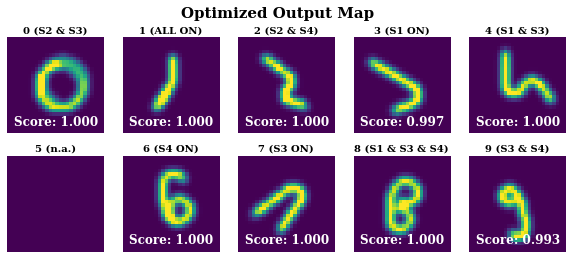

In [18]:
teststrip.plot_selected_output_map()

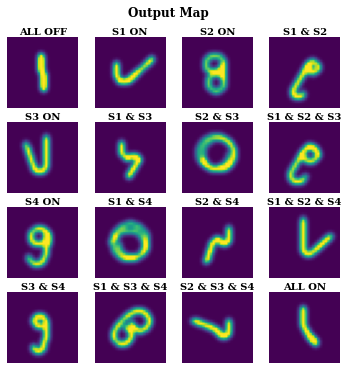

In [19]:
teststrip.plot_output_map(score=False)

In [20]:
teststrip.generate_unscaled_imgs(filter_sigma=.25)

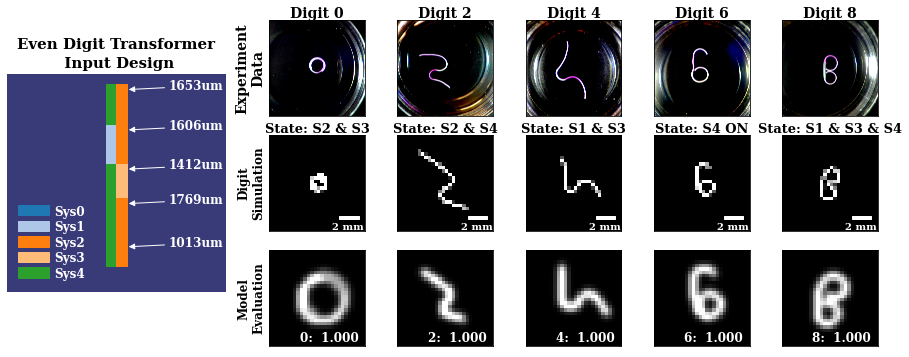

In [30]:
fig = plt.figure(figsize = (18, 6))

ax = plt.subplot(1, 4, 1)

fig_width = int(np.sum(teststrip.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
cm = plt.cm.get_cmap('tab20')
ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
for i in range(len(teststrip.segment_lengths)):
    ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[0][i]]))
    ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[1][i]]))

ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

for i in range(len(teststrip.segment_lengths)):
            ax.annotate("%dum"%(teststrip.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])),\
                        xytext=(fig_width-strip_width*5.5, strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")


plt.title("Even Digit Transformer\n Input Design",\
          linespacing = 1.5, fontsize = 15, family = "serif", weight = "bold")
plt.axis(False); 

plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

for i in range(5):
    ax = plt.subplot(3, 8, 19 + i)
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(teststrip.selected[int(i*2)]["img"], cmap = "gray")
    
#     plt.title("Digit {}".format(int(i*2)),\
#               y = .96, fontsize = 14, family = "serif", weight = "bold")
    if i == 0: plt.ylabel("Model\nEvaluation", fontsize = 12, family = "serif", weight = "bold")
    plt.text(28*.3, 28*.93, "{}:  {:.3f}".format(int(i*2), teststrip.selected[int(i*2)]["score"]),\
                 fontsize = 12, family = "serif", weight = "bold", color = "white")
    
for i in range(5):
    ax = plt.subplot(3, 8, 11 + i)
    ax.set_xticks([]); ax.set_yticks([])
    num = teststrip.selected[int(i*2)]["num"]
    plt.imshow(teststrip.unscaled_imgs[num], cmap = "gray")
    
    plt.title("State: {}".format(teststrip.selected[int(i*2)]["state"]),\
              y = .96, fontsize = 13, family = "serif", weight = "bold")
    if i == 0: plt.ylabel("Digit\nSimulation", fontsize = 12, family = "serif", weight = "bold")
        
    ax.add_patch(matplotlib.patches.Rectangle((20,  23), 5.6, 1, color = "white"))
    ax.text(18, 27, "2 mm", fontsize = 10, color = "white", family = "serif", weight = "bold")
    
#     plt.text(28*.01, 28*.93, "rotate:  {:.0f}$^o$".format(360/np.pi/2*teststrip.output_info[num]["rotations"]),\
#                  fontsize = 12, family = "serif", weight = "bold", color = "white")
    
for i in range(5):
    
    ax = plt.subplot(3, 8, 3 + i)
    ax.set_xticks([]); ax.set_yticks([])
    img = plt.imread("Exp2/{}.jpg".format(int(i*2)))

    pl = 70
    p50, p98 = np.percentile(img, (pl, 98))
    if p98 == 0 and p50 == 0:
        p50, p98 = np.percentile(img, (pl, 99))
    img = exposure.rescale_intensity(img, in_range = (p50, p98))
    
    plt.imshow(img)
    
    if i == 0: plt.ylabel("Experiment\nData", fontsize = 14, family = "serif", weight = "bold")
        
    plt.title("Digit {}".format(int(i*2)),\
          y = .96, fontsize = 14, family = "serif", weight = "bold")
    
# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png", dpi = 900)
plt.show()


## Odd Numbers

In [21]:
idts = [[1, 2, 1, 3, 1],[2, 4, 2, 2, 2]]
sl = [1898, 1138, 1635, 1069, 1199]

cnn_digit_model = load_model("Deep_Learning_Classifier_v3.h5")
teststrip = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)

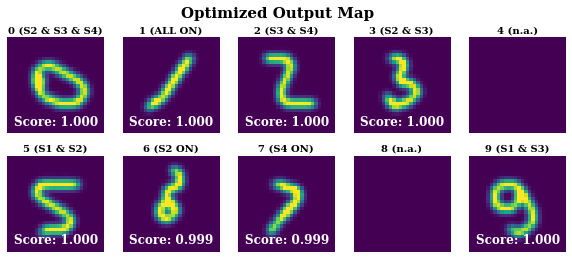

In [22]:
teststrip.plot_selected_output_map()

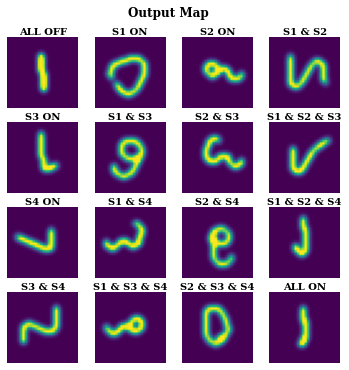

In [23]:
teststrip.plot_output_map(score=False)

In [34]:
teststrip.generate_unscaled_imgs(filter_sigma=.2)

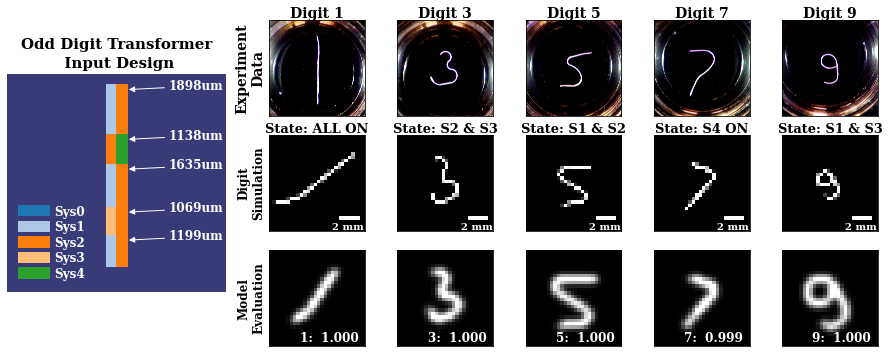

In [36]:
fig = plt.figure(figsize = (18, 6))

ax = plt.subplot(1, 4, 1)

fig_width = int(np.sum(teststrip.segment_lengths) * 1.2); strip_width = int(fig_width/21); shift = int(fig_width*.6)
cm = plt.cm.get_cmap('tab20')
ax.imshow(np.ones(shape=(fig_width, fig_width)), cmap = "tab20b")
for i in range(len(teststrip.segment_lengths)):
    ax.add_patch(matplotlib.patches.Rectangle((fig_width/2-strip_width,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[0][i]]))
    ax.add_patch(matplotlib.patches.Rectangle((fig_width/2,strip_width+np.sum(teststrip.segment_lengths[0:i])),strip_width,teststrip.segment_lengths[i], color = cm.colors[teststrip.identities[1][i]]))

ax.add_patch(matplotlib.patches.Rectangle((strip_width,  shift), strip_width*3, strip_width, color = cm.colors[0]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*1.5+shift), strip_width*3, strip_width, color = cm.colors[1]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*3+shift), strip_width*3, strip_width, color = cm.colors[2]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*4.5+shift), strip_width*3, strip_width, color = cm.colors[3]))
ax.add_patch(matplotlib.patches.Rectangle((strip_width, strip_width*6+shift), strip_width*3, strip_width, color = cm.colors[4]))

ax.text(shift/2.8, strip_width*1+shift, "Sys0", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*2.5+shift, "Sys1", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*4+shift, "Sys2", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*5.5+shift, "Sys3", fontsize = 12, color = "white", family = "serif", weight = "bold")
ax.text(shift/2.8, strip_width*7+shift, "Sys4", fontsize = 12, color = "white", family = "serif", weight = "bold")

for i in range(len(teststrip.segment_lengths)):
            ax.annotate("%dum"%(teststrip.segment_lengths[i]), xy=(fig_width/2+strip_width,strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])),\
                        xytext=(fig_width-strip_width*5.5, strip_width*1.5+np.sum(teststrip.segment_lengths[0:i])),\
                        arrowprops = dict(arrowstyle="-|>", color="white"), fontsize = 12, color = "white", family = "serif", weight = "bold")


plt.title("Odd Digit Transformer\n Input Design",\
          linespacing = 1.5, fontsize = 15, family = "serif", weight = "bold")
plt.axis(False); 

plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

for i in range(5):
    ax = plt.subplot(3, 8, 19 + i)
    ax.set_xticks([]); ax.set_yticks([])
    plt.imshow(teststrip.selected[int(i*2+1)]["img"], cmap = "gray")
    
#     plt.title("Digit {}".format(int(i*2)),\
#               y = .96, fontsize = 14, family = "serif", weight = "bold")
    if i == 0: plt.ylabel("Model\nEvaluation", fontsize = 12, family = "serif", weight = "bold")
    plt.text(28*.3, 28*.93, "{}:  {:.3f}".format(int(i*2+1), teststrip.selected[int(i*2+1)]["score"]),\
                 fontsize = 12, family = "serif", weight = "bold", color = "white")
    
for i in range(5):
    ax = plt.subplot(3, 8, 11 + i)
    ax.set_xticks([]); ax.set_yticks([])
    num = teststrip.selected[int(i*2+1)]["num"]
    plt.imshow(teststrip.unscaled_imgs[num], cmap = "gray")
    
    plt.title("State: {}".format(teststrip.selected[int(i*2+1)]["state"]),\
              y = .96, fontsize = 13, family = "serif", weight = "bold")
    if i == 0: plt.ylabel("Digit\nSimulation", fontsize = 12, family = "serif", weight = "bold")
        
    ax.add_patch(matplotlib.patches.Rectangle((20,  23), 5.6, 1, color = "white"))
    ax.text(18, 27, "2 mm", fontsize = 10, color = "white", family = "serif", weight = "bold")
    
#     plt.text(28*.01, 28*.93, "rotate:  {:.0f}$^o$".format(360/np.pi/2*teststrip.output_info[num]["rotations"]),\
#                  fontsize = 12, family = "serif", weight = "bold", color = "white")
    
for i in range(5):
    
    ax = plt.subplot(3, 8, 3 + i)
    ax.set_xticks([]); ax.set_yticks([])
    img = plt.imread("Exp3/{}.jpg".format(int(i*2+1)))

    pl = 70
    p50, p98 = np.percentile(img, (pl, 98))
    if p98 == 0 and p50 == 0:
        p50, p98 = np.percentile(img, (pl, 99))
    img = exposure.rescale_intensity(img, in_range = (p50, p98))
    
    plt.imshow(img)
    
    if i == 0: plt.ylabel("Experiment\nData", fontsize = 14, family = "serif", weight = "bold")
        
    plt.title("Digit {}".format(int(i*2+1)),\
          y = .96, fontsize = 14, family = "serif", weight = "bold")
    
# plt.savefig(datetime.datetime.now().strftime("%Y%m%d_%H_%M_%S") + "fig.png", dpi = 900)

plt.show()



In [17]:
# # Robustness test and local optimizer
# idts = [[2,3,4,0,3,2],[0,1,3,0,2,2]]
# sl = [1500, 1690, 1330, 1230, 1400, 1320]

# cnn_digit_model = load_model("DigitClassifier_20201014_mod3.h5")
# val = loss_on_dig_sim_var_v2(ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls))

# population = 50
# sl_pop = np.random.normal(sl, scale = 200, size = (population, 6))
# lo_pop = [loss_on_dig_sim_var_v2(ActuatorStrip(i, idts, four_t_rocs, four_t_ctls)) for i in sl_pop]

# fig = plt.figure(figsize = (6, 6))
# plt.title("Loss Population", fontsize = 15, family = "serif", weight = "bold")
# plt.hist(lo_pop)
# plt.axvline(val, color = "k", ls = "--")
# plt.xticks(family = "serif", fontsize = 13, weight = 'bold')
# plt.yticks(family = "serif", fontsize = 13, weight = 'bold')
# plt.show()

## 6 Segmenters

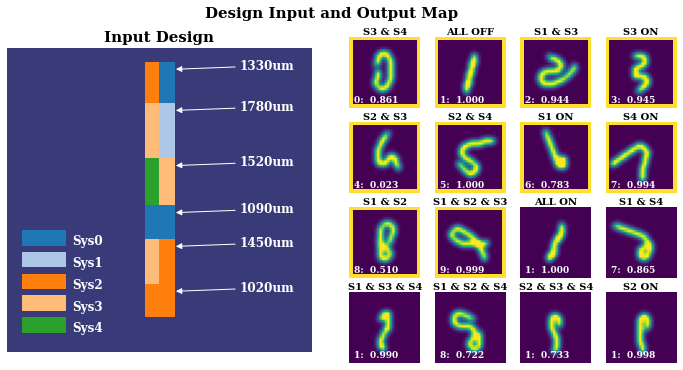

In [18]:
# perfect
idts = [[2,3,4,0,3,2],[0,1,3,0,2,2]]
sl = [1330, 1780, 1520, 1090, 1450, 1020]
cnn_digit_model = load_model("DigitClassifier_20201014_mod3.h5")
teststrip = ActuatorStrip(sl, idts, four_t_rocs, four_t_ctls)
# teststrip.plot_output_map(score = False, save = False)
#                0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15
digit_order =  [12,  0,  5,  4,  6, 10,  1,  8,  3,  7, 15,  9, 13, 11, 14,  2]
rotate_angle = [ 0,  0,-30,140,190,-80, 90,180, 50,280,  0,  0,200,  0,180,180]
score_index =  [ 1,  1,  1,  1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]
    
ultimate_plotter(teststrip, digit_order, rotate_angle, score_index,\
                 test = False, save = False)
